In [145]:
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model, Sequential
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
from sklearn.preprocessing import StandardScaler

In [146]:
import numpy
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
data = pd.read_csv('/home/hr/Documents/creditcardclients.csv')

In [147]:
data.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [148]:
numpy.random.seed(7)
RANDOM_SEED = 42
from sklearn.model_selection import train_test_split
df = data.drop(['ID'], axis=1)
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=RANDOM_SEED)

In [149]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

/home/hr/anaconda3/lib/python3.5/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/hr/anaconda3/lib/python3.5/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/hr/anaconda3/lib/python3.5/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [150]:
input_dim = X_train.shape[1]
encoding_dim = 23
input_layer = Input(shape=(input_dim, ))

encoder = Dense(encoding_dim, activation="selu",activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="softplus",activity_regularizer=regularizers.l1(10e-5))(encoder)
encoder = Dense(int(encoding_dim / 2), activation="selu",activity_regularizer=regularizers.l1(10e-5))(encoder)
encoder = Dense(int(encoding_dim / 4), activation="softplus",activity_regularizer=regularizers.l1(10e-5))(encoder)
encoder = Dense(int(encoding_dim / 4), activation="tanh",activity_regularizer=regularizers.l1(10e-5))(encoder)

decoder = Dense(int(encoding_dim / 4), activation='selu',activity_regularizer=regularizers.l1(10e-5))(encoder)
decoder = Dense(int(encoding_dim / 4), activation='softplus',activity_regularizer=regularizers.l1(10e-5))(decoder)
decoder = Dense(int(encoding_dim / 2), activation='selu',activity_regularizer=regularizers.l1(10e-5))(encoder)
decoder = Dense(int(encoding_dim / 2), activation='softplus',activity_regularizer=regularizers.l1(10e-5))(decoder)
decoder = Dense(input_dim, activation='tanh',activity_regularizer=regularizers.l1(10e-5))(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)

In [151]:
nb_epoch = 150
batch_size = 32

autoencoder.compile(optimizer='adam',loss='mean_squared_error',metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath="model1.h5",verbose=1,save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',histogram_freq=0,write_graph=True,write_images=True)

history = autoencoder.fit(X_train, X_train,epochs=nb_epoch,batch_size=batch_size,shuffle=True,validation_data=(X_test, X_test),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

Train on 21000 samples, validate on 9000 samples
Epoch 1/150
21000/21000 [==============================] - 5s 242us/step - loss: 0.8918 - acc: 0.1432 - val_loss: 0.6974 - val_acc: 0.2220

Epoch 00001: val_loss improved from inf to 0.69738, saving model to model1.h5
Epoch 2/150
21000/21000 [==============================] - 4s 197us/step - loss: 0.7177 - acc: 0.2643 - val_loss: 0.6531 - val_acc: 0.2906

Epoch 00002: val_loss improved from 0.69738 to 0.65308, saving model to model1.h5
Epoch 3/150
21000/21000 [==============================] - 4s 188us/step - loss: 0.6920 - acc: 0.2909 - val_loss: 0.6376 - val_acc: 0.3069

Epoch 00003: val_loss improved from 0.65308 to 0.63757, saving model to model1.h5
Epoch 4/150
21000/21000 [==============================] - 4s 195us/step - loss: 0.6805 - acc: 0.2977 - val_loss: 0.6282 - val_acc: 0.3046

Epoch 00004: val_loss improved from 0.63757 to 0.62818, saving model to model1.h5
Epoch 5/150
21000/21000 [==============================] - 5s 235us


Epoch 00077: val_loss did not improve from 0.48854
Epoch 78/150
21000/21000 [==============================] - 3s 132us/step - loss: 0.5353 - acc: 0.4120 - val_loss: 0.4883 - val_acc: 0.4088

Epoch 00078: val_loss improved from 0.48854 to 0.48829, saving model to model1.h5
Epoch 79/150
21000/21000 [==============================] - 3s 132us/step - loss: 0.5346 - acc: 0.4135 - val_loss: 0.4886 - val_acc: 0.4111

Epoch 00079: val_loss did not improve from 0.48829
Epoch 80/150
21000/21000 [==============================] - 3s 130us/step - loss: 0.5351 - acc: 0.4124 - val_loss: 0.4882 - val_acc: 0.4071

Epoch 00080: val_loss improved from 0.48829 to 0.48824, saving model to model1.h5
Epoch 81/150
21000/21000 [==============================] - 3s 133us/step - loss: 0.5387 - acc: 0.4095 - val_loss: 0.4994 - val_acc: 0.3994

Epoch 00081: val_loss did not improve from 0.48824
Epoch 82/150
21000/21000 [==============================] - 3s 129us/step - loss: 0.5384 - acc: 0.4123 - val_loss: 0.4

21000/21000 [==============================] - 3s 129us/step - loss: 0.5241 - acc: 0.4175 - val_loss: 0.4774 - val_acc: 0.4166

Epoch 00118: val_loss improved from 0.47764 to 0.47738, saving model to model1.h5
Epoch 119/150
21000/21000 [==============================] - 3s 129us/step - loss: 0.5235 - acc: 0.4193 - val_loss: 0.4774 - val_acc: 0.4163

Epoch 00119: val_loss did not improve from 0.47738
Epoch 120/150
21000/21000 [==============================] - 3s 130us/step - loss: 0.5319 - acc: 0.4152 - val_loss: 0.4829 - val_acc: 0.4218

Epoch 00120: val_loss did not improve from 0.47738
Epoch 121/150
21000/21000 [==============================] - 3s 133us/step - loss: 0.5269 - acc: 0.4168 - val_loss: 0.4791 - val_acc: 0.4211

Epoch 00121: val_loss did not improve from 0.47738
Epoch 122/150
21000/21000 [==============================] - 3s 130us/step - loss: 0.5243 - acc: 0.4163 - val_loss: 0.4771 - val_acc: 0.4162

Epoch 00122: val_loss improved from 0.47738 to 0.47713, saving model 

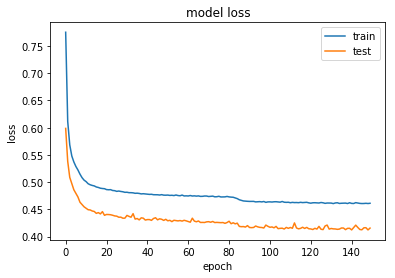

In [135]:
autoencoder = load_model('model1.h5')
import pickle
import matplotlib.pyplot as plt
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

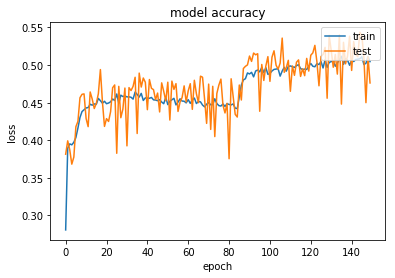

In [136]:
plt.plot(history['acc'])
plt.plot(history['val_acc'])
plt.title('model accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

In [65]:
predictions = autoencoder.predict(X_test)

In [66]:
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})

In [67]:
error_df.describe()

,reconstruction_error,true_class
count,3.000000e+03,3000.000000
mean,3.504049e+09,0.219667
std,5.951238e+09,0.414090
min,3.860732e+06,0.000000
25%,3.881548e+08,0.000000
50%,1.508956e+09,0.000000
75%,4.300777e+09,0.000000
max,7.304388e+10,1.000000
